In [778]:
#Look at chevbot video - Extract trajectory, distance vs time, and inst velocity vs laser distance from beam center
#CKH Sept 14 2018
import numpy as np

In [779]:
inputfile = "Video12Analysis.csv"
positiondata= np.loadtxt(inputfile, delimiter=',',skiprows=1)

In [780]:
#each element of positiondata is a list: laser centroid x, laser centroid y, xspeck left, yspeck left, xspeck right,
#yspeck right, xinner fishtail, y innner fishtail, x outer fishtail, y outer fishtail, time (sec)
#we have to use the specks as references because the camera is moving.

In [781]:
def getCoords(p): #Return laser and chevron center referenced to the 2 specks, LeftSpeck is at the origin 0,0
    #and RightSpeck is going to be put horizontal from LeftSpeck. 
    LaserX=p[0]
    LaserY=-p[1]
    LeftSpeckX=p[2]
    LeftSpeckY=-p[3]
    RightSpeckX=p[4]
    RightSpeckY=-p[5]
    InnerFishtailX=p[6]
    InnerFishtailY=-p[7]
    OuterFishtailX=p[8]
    OuterFishtailY=-p[9]#minus signs because y coord is flipped in photoshop
    
    #Collected 2 coords on the robot so could get the body direction vector but did not implement yet
    ChevronCenterX=(InnerFishtailX+OuterFishtailX)/2.0
    ChevronCenterY=(InnerFishtailY+OuterFishtailY)/2.0 #So here I am just getting the chevron center.
    
    SpeckTheta=getTheta(LeftSpeckX,LeftSpeckY,RightSpeckX,RightSpeckY)
    LaserR = getR(LeftSpeckX,LeftSpeckY,LaserX,LaserY)
    LaserTheta = getTheta(LeftSpeckX,LeftSpeckY,LaserX,LaserY)-SpeckTheta
    ReferencedLaserX,ReferencedLaserY=pol2cart(LaserR,LaserTheta)
    ChevronR = getR(LeftSpeckX,LeftSpeckY,ChevronCenterX,ChevronCenterY)
    ChevronTheta = getTheta(LeftSpeckX,LeftSpeckY,ChevronCenterX,ChevronCenterY)-SpeckTheta
    ReferencedChevronX,ReferencedChevronY=pol2cart(ChevronR,ChevronTheta)
    #check where it thinks the right speck should go, it should have y=0 and nearly constant x after rotating horizontal
    RightSpeckR=getR(LeftSpeckX,LeftSpeckY,RightSpeckX,RightSpeckY)
    ReferencedRightSpeckX,ReferencedRightSpeckY=pol2cart(RightSpeckR,0)
    return[ReferencedLaserX,ReferencedLaserY,ReferencedChevronX,ReferencedChevronY, ReferencedRightSpeckX,ReferencedRightSpeckY,SpeckTheta]
    

In [782]:
def getTime(p):
    return p[10]
    

In [783]:
def getR (X1,Y1,X2,Y2):
    return np.sqrt((X2-X1)**2+(Y2-Y1)**2)

In [784]:
def getTheta (X1,Y1,X2,Y2):
    #return np.arctan((Y2-Y1)/(X2-X1))
    return np.arctan2(Y2-Y1,X2-X1)

In [785]:
def pol2cart(R,Theta):
    x=R*np.cos(Theta)
    y=R*np.sin(Theta)
    return[x,y]

In [786]:
laserx=[]
lasery=[]
botx=[]
boty=[]
time=[]
rightspeckx=[]
rightspecky=[]
specktheta=[]

for pos in positiondata:
    lx,ly,bx,by,rsx,rsy,st=getCoords(pos)
    t=getTime(pos)
    laserx.append(lx)
    lasery.append(ly)
    botx.append(bx)
    boty.append(by)
    rightspeckx.append(rsx)
    rightspecky.append(rsy)
    specktheta.append(st)
    time.append(t)
    
#change from pixels to microns!
#43 pixels is about 80 microns so the factor is 80.0/43
micronPerPx=80.0/43.0
laserxMicrons=np.array(laserx)*micronPerPx
laseryMicrons=np.array(lasery)*micronPerPx
botxMicrons=np.array(botx)*micronPerPx
botyMicrons=np.array(boty)*micronPerPx
rightspeckxMicrons=np.array(rightspeckx)*micronPerPx
rightspeckyMicrons=np.array(rightspecky)*micronPerPx
#speckThetaDeg=np.array(specktheta)*180.0/np.pi
#rightspeckxMicrons,speckThetaDeg #yes these angles are what photoshop gives

In [787]:
positiondata[0]

array([ 576.,  335.,  422.,  131.,  649.,   99.,  543.,  313.,  550.,
        265.,    0.])

array([ 190.45010416,  193.81771491,  204.24880094,  200.21484536,
        205.09665699,  203.9095167 ,  205.22990744,  205.09665699,
        203.87275743])

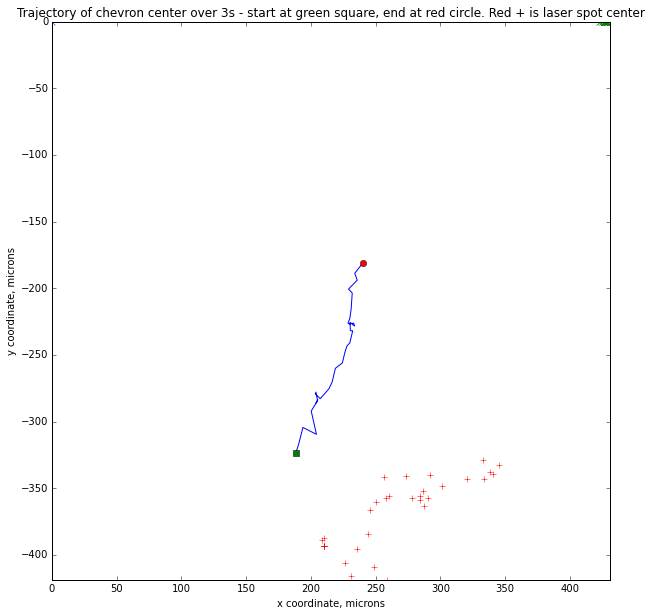

In [808]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=[10,10])
plt.axis('equal')
plt.plot(botxMicrons,botyMicrons)
plt.plot(laserxMicrons,laseryMicrons,'r+')
plt.title('Trajectory of chevron center over 3s - start at green square, end at red circle. Red + is laser spot center')
plt.xlabel('x coordinate, microns')
plt.ylabel('y coordinate, microns')
plt.hold ('true')
plt.plot(botxMicrons[0],botyMicrons[0],'gs')
plt.plot(botxMicrons[-1],botyMicrons[-1],'ro')
plt.plot(rightspeckxMicrons,rightspeckyMicrons,'gx') #Show right reference speck as a green x
#Left reference speck is always mapped to 0,0
plt.plot(0,0,'bx')#Force left speck to show up on the plot
plt.axis('tight')
botxMicrons[1:10]

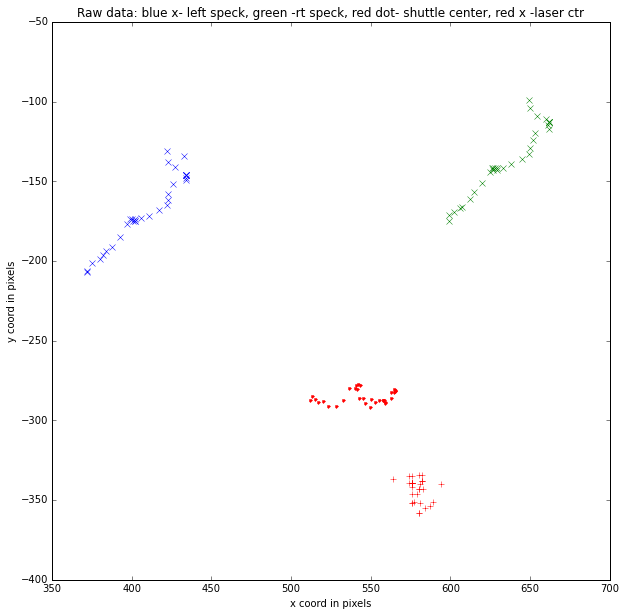

In [800]:
#Plot raw data, show how left and right speck had moved around during filming
plt.figure(figsize=[10,10])
plt.hold('true')
plt.axis('equal')
plt.title('Raw data: blue x- left speck, green -rt speck, red dot- shuttle center, red x -laser ctr')
plt.xlabel('x coord in pixels')
plt.ylabel('y coord in pixels')
for pos in positiondata:
    lx,ly,rsx,rsy,lsx,lsy,ifx,ify,ofx,ofy,t=pos  #minus signs below because y-coord is flipped in photoshop
    plt.plot(lx,-ly,'r+')  #laser spot center- probably has more error than the others, it was a diffuse shape
    plt.plot(rsx,-rsy,'bx') #left speck, I map this to 0,0
    plt.plot(lsx,-lsy,'gx') #right speck - I make this horizontal
    plt.plot((ifx+ofx)/2.0,-(ify+ofy)/2.0,'r.') #center of shuttle on robot
    
    
    
    

In [790]:
#instantaneous speed in microns/second
instspd=[np.sqrt((botxMicrons[i+1]-botxMicrons[i])**2+(botyMicrons[i+1]-botyMicrons[i])**2)/(time[i+1]-time[i]) for i in range(len(botxMicrons)-1)]

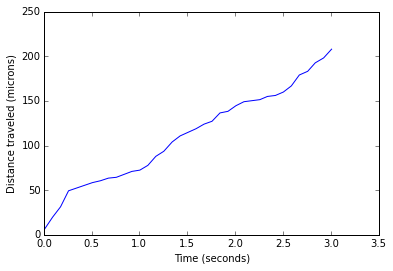

In [791]:
#accumulative distance traveled (in microns)
deltad=[np.sqrt((botxMicrons[i+1]-botxMicrons[i])**2+(botyMicrons[i+1]-botyMicrons[i])**2) for i in range(len(botxMicrons)-1)]
distTraveled=np.cumsum(deltad)
plt.plot(time[1:],distTraveled)
plt.xlabel('Time (seconds)')
plt.ylabel ('Distance traveled (microns)')

In [792]:
#compare total distance traveled along trajectory, to straight-line distance
TotalTrajDist=distTraveled[-1] #last element
StraightLineDist=np.sqrt((botxMicrons[-1]-botxMicrons[0])**2+(botyMicrons[-1]-botyMicrons[0])**2)

#Ruoshi got 46 microns/s from straight line analysis of video. He measured over a longer time than I did
StraightLineAvgVel=StraightLineDist/(time[-1]-time[0])
TrajAvgVel=TotalTrajDist/(time[-1]-time[0])
TotalTrajDist,StraightLineDist,TrajAvgVel,StraightLineAvgVel
#Yes straight line avg vel is slower (because distance is shorter for same time) and this is close to what Ruoshi got

(207.93166802106828,
 151.38934074579507,
 69.118560014661867,
 50.323326569275181)

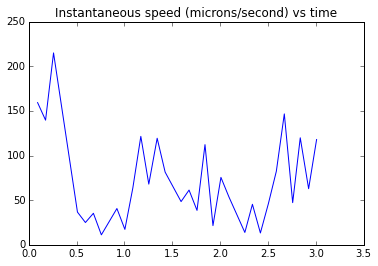

In [793]:
plt.plot(time[2:],instspd[1:])
plt.title('Instantaneous speed (microns/second) vs time')

(0.0, 3.0083333329999999, 6.4735832389568548, 207.93166802106828)

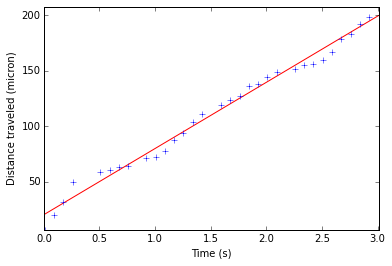

In [794]:
#Average speed from averaging instantaneous velocity
avgspd=np.average(instvel)

#Average speed from fitting cumulative distance data - should be the slope
poly=np.polyfit(time[1:],distTraveled,1)  #gives slope and y-intercept



#plot the fit on top of the distance data
fitline=[np.polyval(poly,t) for t in time]
plt.plot(time,fitline,'r')
plt.hold('true')
plt.plot(time[1:],distTraveled,'b+')
plt.xlabel('Time (s)')
plt.ylabel('Distance traveled (micron)')
plt.axis('tight')
plt.title('Average speed from slope of distance vs time plot = 60 micron/s')

In [795]:
#compare slope and the instantaneous average  -
poly[0],avgspd

(59.754868374829037, 112.98466167822428)

In [796]:
#distance of laser spot center from chevron center in microns
laserdist=[np.sqrt((laserxMicrons[i]-botxMicrons[i])**2+(laseryMicrons[i]-botyMicrons[i])**2) for i in range(len(botxMicrons))]
laserdist

[101.66807784649822,
 122.45903057684848,
 100.38325691735035,
 99.134164025398476,
 101.52754343919824,
 108.91668733928093,
 107.2715856009368,
 109.83049036759401,
 108.91668733928093,
 110.9202374708245,
 108.18328697314425,
 132.71064258970014,
 112.86906891236583,
 100.70599890399528,
 104.86489801705642,
 106.10361579615903,
 113.63315202698973,
 124.44272750281411,
 126.93840463863256,
 142.62622146062105,
 113.14473326330507,
 123.24089422644981,
 134.80671418475976,
 128.25744796445881,
 143.10169904041359,
 145.51228019820275,
 144.41092740706995,
 155.96036162105852,
 172.38190712407072,
 178.35496112506425,
 166.44925426549119,
 182.23300924715937,
 184.34571420896856]

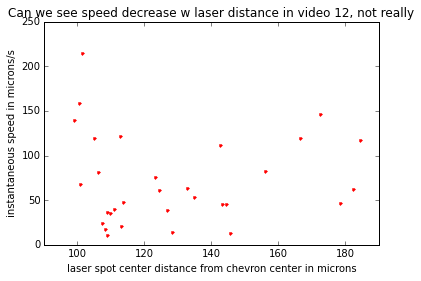

In [806]:
plt.plot(laserdist[2:],instspd[1:],'r.')
plt.xlabel('laser spot center distance from chevron center in microns')
plt.ylabel('instantaneous speed in microns/s')
plt.title('Can we see speed decrease w/ laser distance in video 12, not really')